# [IAPR 2019:][iapr2019] Lab 1 ‒  Image segmentation

**Author:** Arash Askari  
**Due date:** 04.04.2019

[iapr2019]: https://github.com/LTS5/iapr-2019

In [1]:
## Load necessary packages and instances
import os
import numpy as np
from scipy import ndimage,misc
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
import tarfile
import skimage.io
from skimage.filters import median,sobel_v,sobel_h
from skimage.morphology import disk, square, rectangle, opening, closing, binary_closing
from skimage import exposure, feature,img_as_float
from skimage.measure import label, regionprops
from skimage.color import label2rgb
import matplotlib.patches as mpatches
from statistics import stdev, mean, mode
from sklearn.cluster import KMeans 
from IPython.display import HTML, display
from skimage.segmentation import chan_vese

print(os.getcwd())  ## obtain current working directory

C:\Users\askari\iapr-2019


#### Define plot functions used for various plotting formats

In [2]:
def multipleImgHistGenerator(f_imageList, f_titleList, f_cmap):
    fig = plt.figure(figsize=(20,5 * len(f_imageList)))
    itemCounter = 0
    for f_imageItem in f_imageList:
        ax1 = plt.subplot2grid((len(f_imageList),2), (itemCounter,0), rowspan=1, colspan=1)
        ax2 = plt.subplot2grid((len(f_imageList),2), (itemCounter,1), rowspan=1, colspan=1)
        ax1.imshow(f_imageItem, cmap=f_cmap[itemCounter])
        ax1.set_title(f_titleList[itemCounter])
        ax2.hist(f_imageItem.ravel(), bins=256)
        ax2.set_title('Histogram')
        itemCounter += 1

    plt.show()

In [3]:
def multipleImgHistGeneratorOtsu(f_originalImage, f_imageList, f_titleList, f_cmap, f_threshList, f_threshLineColor):
    fig = plt.figure(figsize=(20,5 * len(f_imageList)))
    itemCounter = 0
    for f_imageItem in f_imageList:
        ax1 = plt.subplot2grid((len(f_imageList),2), (itemCounter,0), rowspan=1, colspan=1)
        ax2 = plt.subplot2grid((len(f_imageList),2), (itemCounter,1), rowspan=1, colspan=1)
        ax1.imshow(f_imageItem, cmap=f_cmap[itemCounter])
        ax1.set_title(f_titleList[itemCounter])
        ax2.hist(f_originalImage[itemCounter//2].ravel(), bins=256)
        threshCounter = 0
        for f_threshItem in f_threshList[itemCounter]:
            ax2.axvline(f_threshList[itemCounter][threshCounter], color=f_threshLineColor[itemCounter][threshCounter])
            threshCounter += 1
        ax2.set_title('Histogram')
        itemCounter += 1

    plt.show()

In [4]:
def multiplePlot3x3(f_originalImage, f_thresholdedImage, f_morphThreshImage, f_titleList):
    fig = plt.figure(figsize=(15,5 * len(f_originalImage)))
    itemCounter = 0
    for f_imageItem in f_originalImage:
        ax1 = plt.subplot2grid((len(f_originalImage),3), (itemCounter,0), rowspan=1, colspan=1)
        ax2 = plt.subplot2grid((len(f_originalImage),3), (itemCounter,1), rowspan=1, colspan=1)
        ax3 = plt.subplot2grid((len(f_originalImage),3), (itemCounter,2), rowspan=1, colspan=1)
        ax1.imshow(f_originalImage[itemCounter], cmap = 'gray')
        ax1.set_title(f_titleList[itemCounter])
        ax2.imshow(f_thresholdedImage[itemCounter], cmap = 'gray')
        ax2.set_title("Thresholded (" + f_titleList[itemCounter] + ")")
        ax3.imshow(f_morphThreshImage[itemCounter], cmap = 'gray')
        ax3.set_title("Using Morphology (" + f_titleList[itemCounter] + ")")
        itemCounter += 1

    plt.show()

In [5]:
def multiplePlot2x2(f_ImageList, f_titleList, f_cmapList):
    fig = plt.figure(figsize=(10,5 * len(f_ImageList)))
    itemCounter = 0
    for f_imageItem in f_ImageList:
        ax1 = plt.subplot2grid((len(f_ImageList),2), (itemCounter // 2,itemCounter % 2), rowspan=1, colspan=1)
        ax1.imshow(f_ImageList[itemCounter], cmap = f_cmapList[itemCounter])
        ax1.set_title(f_titleList[itemCounter])
        itemCounter += 1

    plt.show()

In [6]:
def brainRegionPlot(f_labelImage, f_titleList):
    fig = plt.figure(figsize=(7,7 * len(f_labelImage)))
    itemCounter = 0
    for f_imageItem in f_labelImage:
        f_imageLabelOverlay = label2rgb(f_imageItem, image=brain_im) # Overlay the resulted labels on the original image
        regions = regionprops(f_imageItem)
        area=[]
        
        for regionItem in range(0,len(regions)):
            area.append(regions[regionItem].area)
            
        ax = plt.subplot2grid((len(f_labelImage),1), (itemCounter,0), rowspan=1, colspan=1)
        ax.imshow(f_imageLabelOverlay)
        
        # Considering brain is the largest region in the image
        brainRegion = area.index(max(area))
        minr, minc, maxr, maxc = regions[brainRegion].bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr, fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)
        ttl = f_titleList[itemCounter] + ': Area of brain=' + str(max(area)) + 'pixels'
        ax.set_title(ttl)
        itemCounter += 1
        
    plt.tight_layout()
    plt.show()

## Extract relevant data
We first need to extract the `lab-01-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

The path variables are changed to math with the current file path.

In [7]:
data_base_path = os.path.join(os.getcwd(), 'data')
data_folder = 'lab-01-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

## Part 1: Brain segmentation

Your goal: compute the size of the brain (in pixels) in a 2D image of a human head taken by Magnetic Resonance Imaging (MRI).
* Try as many methods as you can, the more the better.
* At least region growing and contour detection.

### 1.1 Brain image visualization

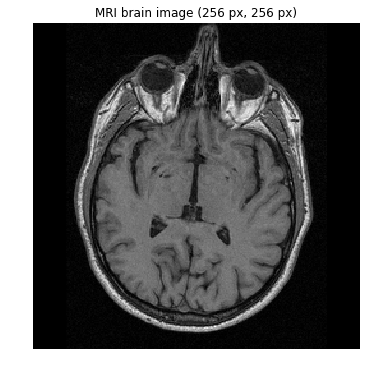

In [8]:
# Load image
data_path = os.path.join(data_base_path, data_folder)
brain_im = skimage.io.imread(os.path.join(data_path, 'brain-slice40.tiff'))
im_h, im_w = brain_im.shape

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_im, cmap='gray')
ax.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()

## 1.2 Region growing
### 1.2.1 Histogram of the Image 
At the first step, the histogram of the gray sacle image is ploted.

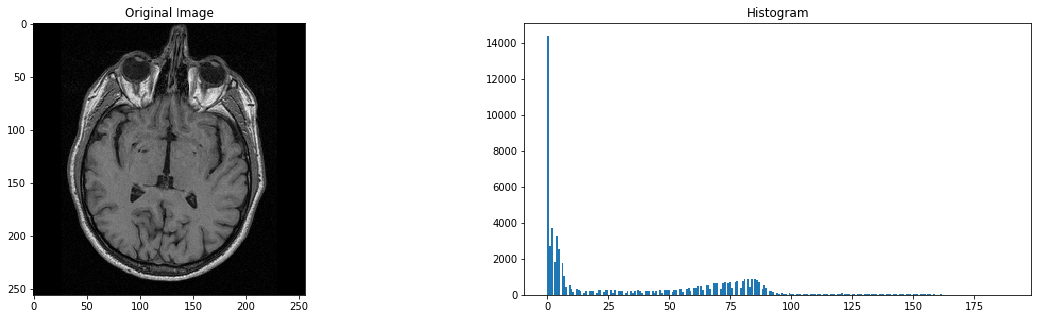

In [9]:
multipleImgHistGenerator([brain_im], ['Original Image'], ['gray'])

As seen in the original image and its corresponding histogram, the gray area of the brain shall be extracted to calculate the brain size. To remove any possible noise off the image, "median" filter is applied to remove the noises while preserving the edges.

### 1.2.2  Removing Noise

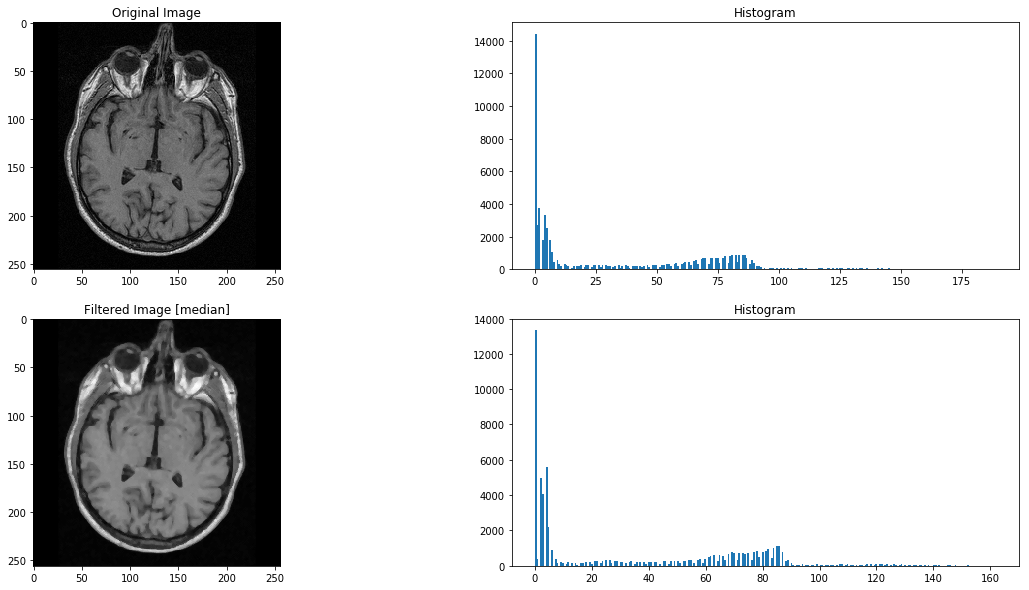

In [10]:
median_brain_im=median(brain_im, disk(2))

multipleImgHistGenerator([brain_im, median_brain_im], ['Original Image', 'Filtered Image [median]'], ['gray', 'gray'])

### 1.2.3  Contrast Adjustment
First we determine if the image **is low contrast**:

In [11]:
skimage.exposure.is_low_contrast(brain_im)

False

The whole image is not low contrasted. The white to black range creates a reasonable contrast. To calculate the brain size, an adequate contrast shall be present in the dark level range (grey - black).

In [12]:
skimage.exposure.is_low_contrast(brain_im, upper_percentile = 50)

True

To increase the contrast between brain and other areas, different methods including "Contrast Stretching", "Histogram Equalization" and "Adaptive Histogram Equalization" are used. 

##### 1.2.3.1 Contrast Stretching 
In this method, the intensity values less than a lower bound (50) are set to 0; the intesity values higher than the upper bound (110) are set to 255 and the intensities between lower and upper bound are linearly interpolated. The upper and lower band intensities are defined to increase the contrast of white and black parts in the original image with the gray-ish brain parts.

##### 1.2.3.2 Histogram Equalization
This method spreads out the most frequent intensity values in the histogram of the image so that the cumulative distribution function (CDF) of the image becomes a straight line.

##### 1.2.3.3 Adaptive Histogram Eqaulization
In this algorithm, instead the whole image, histogram equalization is done on small patches.

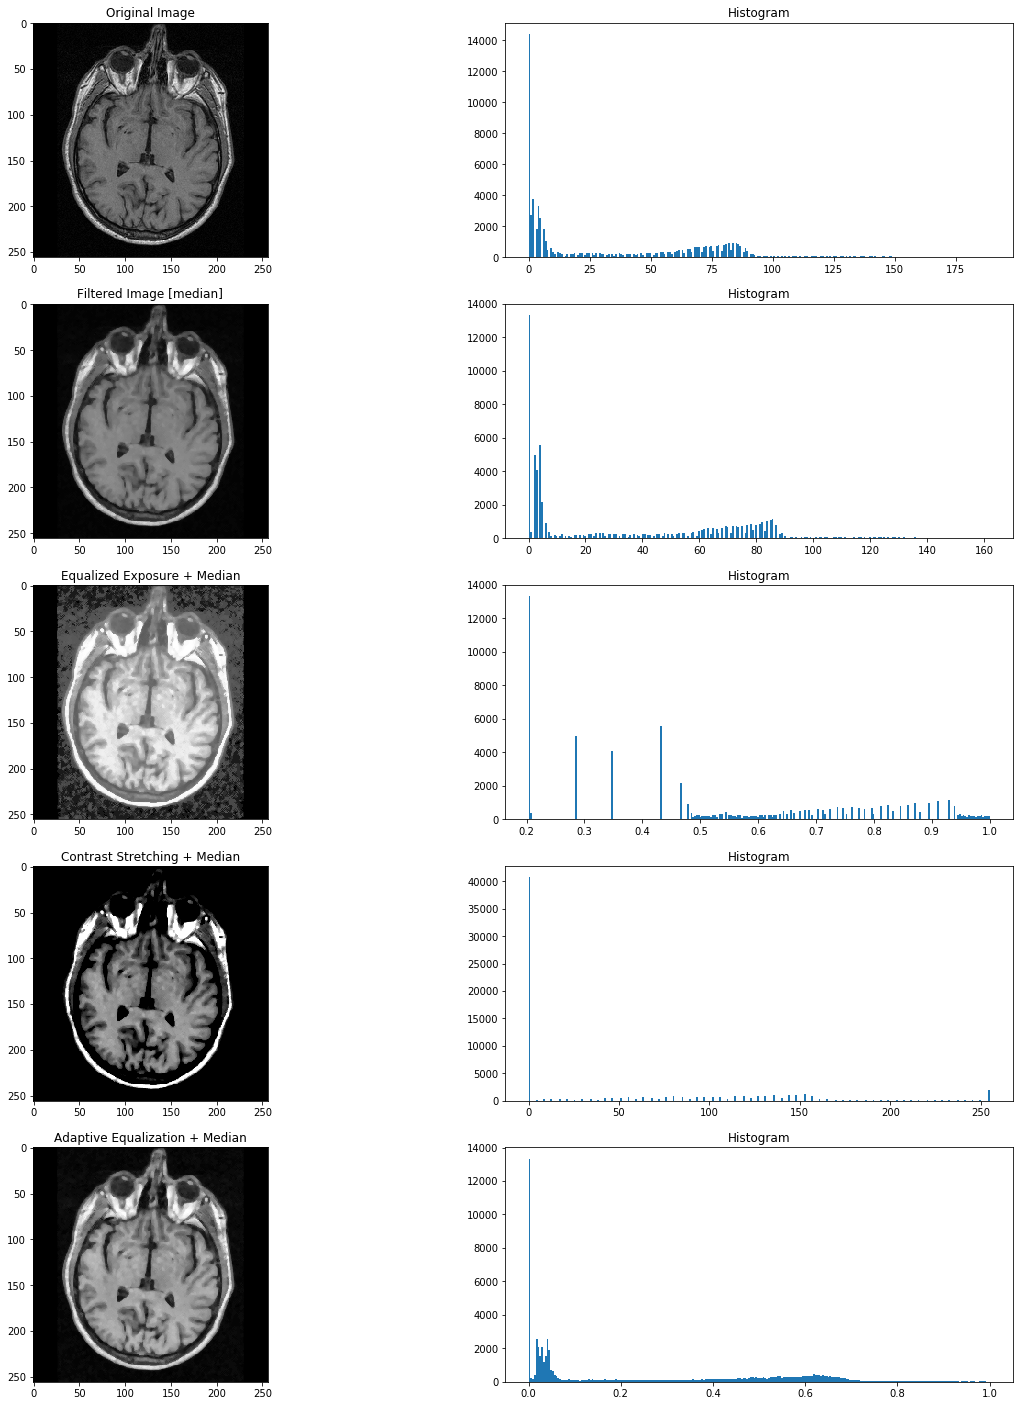

In [13]:
exEqualize_median = skimage.exposure.equalize_hist(median_brain_im)
exStretch_median = exposure.rescale_intensity(median_brain_im, in_range=(50,110))
exadapthist_median = skimage.exposure.equalize_adapthist(median_brain_im, clip_limit = 0.01)

multipleImgHistGenerator([brain_im, median_brain_im, exEqualize_median, exStretch_median, exadapthist_median], 
                         ['Original Image', 'Filtered Image [median]', 'Equalized Exposure + Median', 'Contrast Stretching + Median', 'Adaptive Equalization + Median'], 
                         ['gray', 'gray', 'gray', 'gray', 'gray'])

As we need three regions of grey levels (white-grey-black) in the image, the original image, the denoised image, and the images resulted from application of contrast stretching and adaptive equalization on the denoised image were slected for the next steps.

At this stage, different thresholds are applied to the original and modified images so that the regions are distinguished from each other.

### 1.2.4  Thresholding
##### 1.2.4.1 Procedure description
Below a description of the performed procedure for image thresholding is provided.

First round of thresholding is applied to the images:

In [14]:
thOtsu_brain_im1 = skimage.filters.threshold_otsu(brain_im)
Otsu_brain_im1 = brain_im > thOtsu_brain_im1

multipleImgHistGeneratorOtsu([brain_im], [Otsu_brain_im1],
                         ['OTSU tresholding (Original Image) - 1 Round'], 
                         ['gray'], 
                         [[thOtsu_brain_im1]], 
                         [['r']])


As seen, some bright parts of the picture are also considered in the threshold. Therefore, it would be nice to apply another threshold to the non-black parts of the image to differentiate the gray and white sections.

In [15]:
thOtsu_brain_im2 = skimage.filters.threshold_otsu(brain_im[Otsu_brain_im1])
Otsu_brain_im2 = brain_im > thOtsu_brain_im2

multipleImgHistGeneratorOtsu([brain_im], [Otsu_brain_im2],
                         ['OTSU tresholding (Original Image) - 2 Rounds'], 
                         ['gray'], 
                         [[thOtsu_brain_im2]], 
                         [['g']])

Now that the brightest parts of the image are extracted, let's subtract them from the 1-Round thresholded image.

In [16]:
Otsu_brain_im = Otsu_brain_im1 ^ Otsu_brain_im2

multipleImgHistGeneratorOtsu([brain_im], [Otsu_brain_im],
                         ['OTSU tresholding (Original Image) - 2 Rounds'], 
                         ['gray'], 
                         [[thOtsu_brain_im1, thOtsu_brain_im2]], 
                         [['r', 'g']])

The same is done on other selected images:

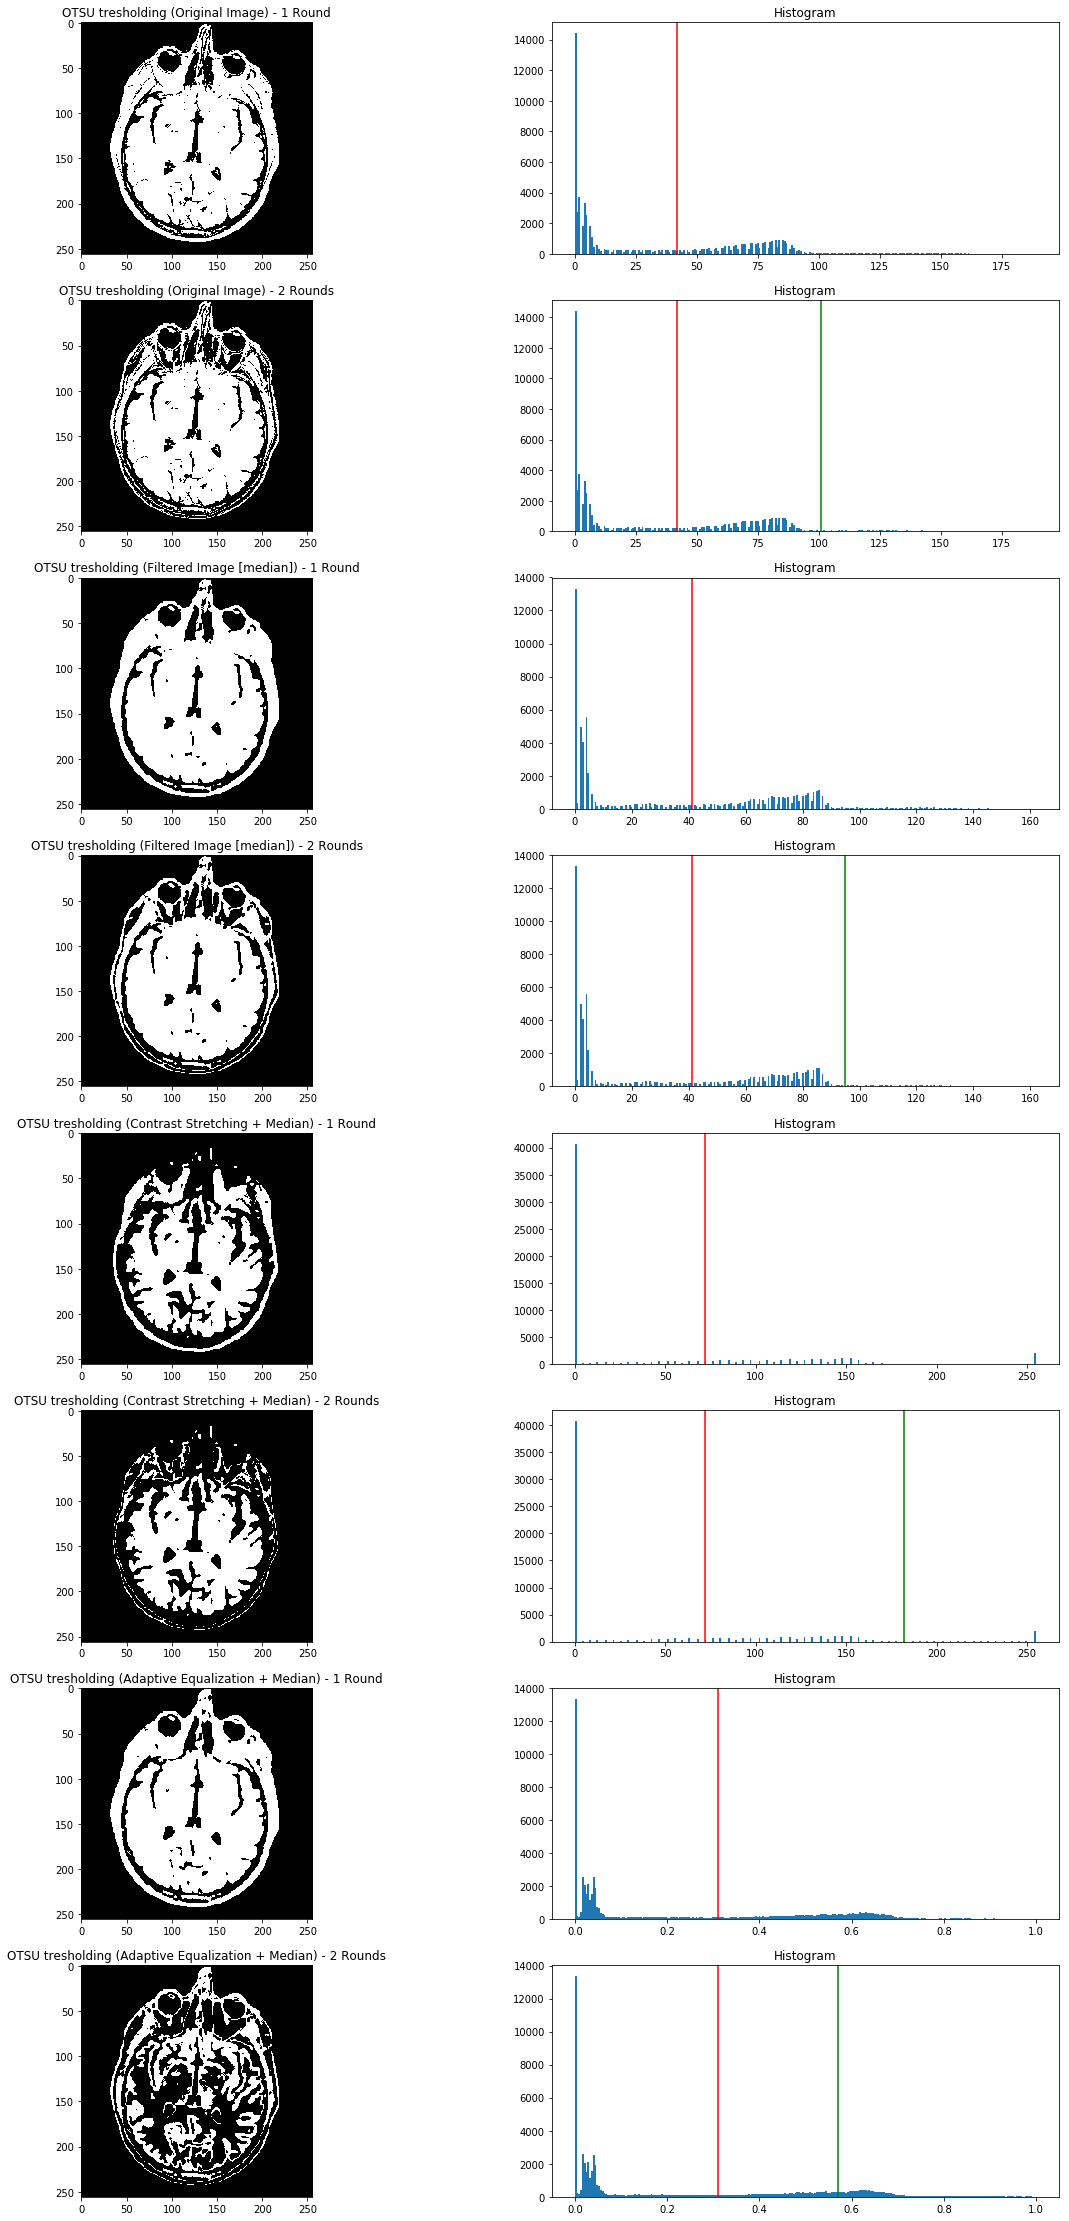

In [17]:
# Original Image
thOtsu_brain_im1 = skimage.filters.threshold_otsu(brain_im)
Otsu_brain_im1 = brain_im > thOtsu_brain_im1
thOtsu_brain_im2 = skimage.filters.threshold_otsu(brain_im[Otsu_brain_im1])
Otsu_brain_im2 = brain_im > thOtsu_brain_im2
Otsu_brain_im = Otsu_brain_im1 ^ Otsu_brain_im2

# Denoised Image
thOtsu_median_brain_im1 = skimage.filters.threshold_otsu(median_brain_im)
Otsu_median_brain_im1 = median_brain_im > thOtsu_median_brain_im1
thOtsu_median_brain_im2 = skimage.filters.threshold_otsu(median_brain_im[Otsu_median_brain_im1])
Otsu_median_brain_im2 = median_brain_im > thOtsu_median_brain_im2
Otsu_median_brain_im = Otsu_median_brain_im1 ^ Otsu_median_brain_im2

# Contrast Stretching on the Denoised Image
thOtsu_exStretch_median1 = skimage.filters.threshold_otsu(exStretch_median)
Otsu_exStretch_median1 = exStretch_median > thOtsu_exStretch_median1
thOtsu_exStretch_median2 = skimage.filters.threshold_otsu(exStretch_median[Otsu_exStretch_median1])
Otsu_exStretch_median2 = exStretch_median > thOtsu_exStretch_median2
Otsu_exStretch_median = Otsu_exStretch_median1 ^ Otsu_exStretch_median2

# Adaptive Equalization on the Denoised Image
thOtsu_exadapthist_median1 = skimage.filters.threshold_otsu(exadapthist_median)
Otsu_exadapthist_median1 = exadapthist_median > thOtsu_exadapthist_median1
thOtsu_exadapthist_median2 = skimage.filters.threshold_otsu(exadapthist_median[Otsu_exadapthist_median1])
Otsu_exadapthist_median2 = exadapthist_median > thOtsu_exadapthist_median2
Otsu_exadapthist_median = Otsu_exadapthist_median1 ^ Otsu_exadapthist_median2

multipleImgHistGeneratorOtsu([brain_im, median_brain_im, exStretch_median, exadapthist_median],
                             [Otsu_brain_im1, Otsu_brain_im, Otsu_median_brain_im1, Otsu_median_brain_im, 
                              Otsu_exStretch_median1, Otsu_exStretch_median, Otsu_exadapthist_median1, Otsu_exadapthist_median],
                         ['OTSU tresholding (Original Image) - 1 Round', 'OTSU tresholding (Original Image) - 2 Rounds',
                          'OTSU tresholding (Filtered Image [median]) - 1 Round', 'OTSU tresholding (Filtered Image [median]) - 2 Rounds', 
                          'OTSU tresholding (Contrast Stretching + Median) - 1 Round', 'OTSU tresholding (Contrast Stretching + Median) - 2 Rounds', 
                          'OTSU tresholding (Adaptive Equalization + Median) - 1 Round', 'OTSU tresholding (Adaptive Equalization + Median) - 2 Rounds'], 
                         ['gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray'], 
                         [[thOtsu_brain_im1], [thOtsu_brain_im1, thOtsu_brain_im2], 
                          [thOtsu_median_brain_im1], [thOtsu_median_brain_im1, thOtsu_median_brain_im2], 
                          [thOtsu_exStretch_median1], [thOtsu_exStretch_median1, thOtsu_exStretch_median2], 
                          [thOtsu_exadapthist_median1], [thOtsu_exadapthist_median1, thOtsu_exadapthist_median2]], 
                         [['r'], ['r', 'g'], ['r'], ['r', 'g'], ['r'], ['r', 'g'], ['r'], ['r', 'g']])

It seems that some light-gray parts of the brain are ommited by the thresjolding in the 2nd round. A third round of thresholding is applied to the "Otsu_exadapthist_median2" as it contains the bright parts of the image. Darker sections of this part are related to the brain.

In [18]:
thOtsu_exadapthist_median3 = skimage.filters.threshold_otsu(exadapthist_median[Otsu_exadapthist_median2])
Otsu_exadapthist_median3 = exadapthist_median > thOtsu_exadapthist_median3  # The brightest parts of the image
Otsu_exadapthist_median = Otsu_exadapthist_median1 ^ (Otsu_exadapthist_median2 & Otsu_exadapthist_median3)
multipleImgHistGeneratorOtsu([exadapthist_median], [Otsu_exadapthist_median],
                         ['OTSU tresholding (Adaptive Equalization + Median) - 3 Rounds'], 
                         ['gray'], 
                         [[thOtsu_exadapthist_median1, thOtsu_exadapthist_median2, thOtsu_exadapthist_median3]], 
                         [['r', 'g', 'b']])

Now it seems much better.

From the above implementations, it can be concluded that the original image does not respond to the thresholding very well as it seems to need additional opening/closing procedures. On the other hand, equalized images are somehow ready for segmentation. 

Two-round thresholded images are selected for further operations - except for the adaptive equalization that a 3rd round was necessary.

### 1.2.5  Morphology Application
A few rounds of morphological methods are applied to the images to remove the unwanted bright/dark spots in the vicinity of the brain region.

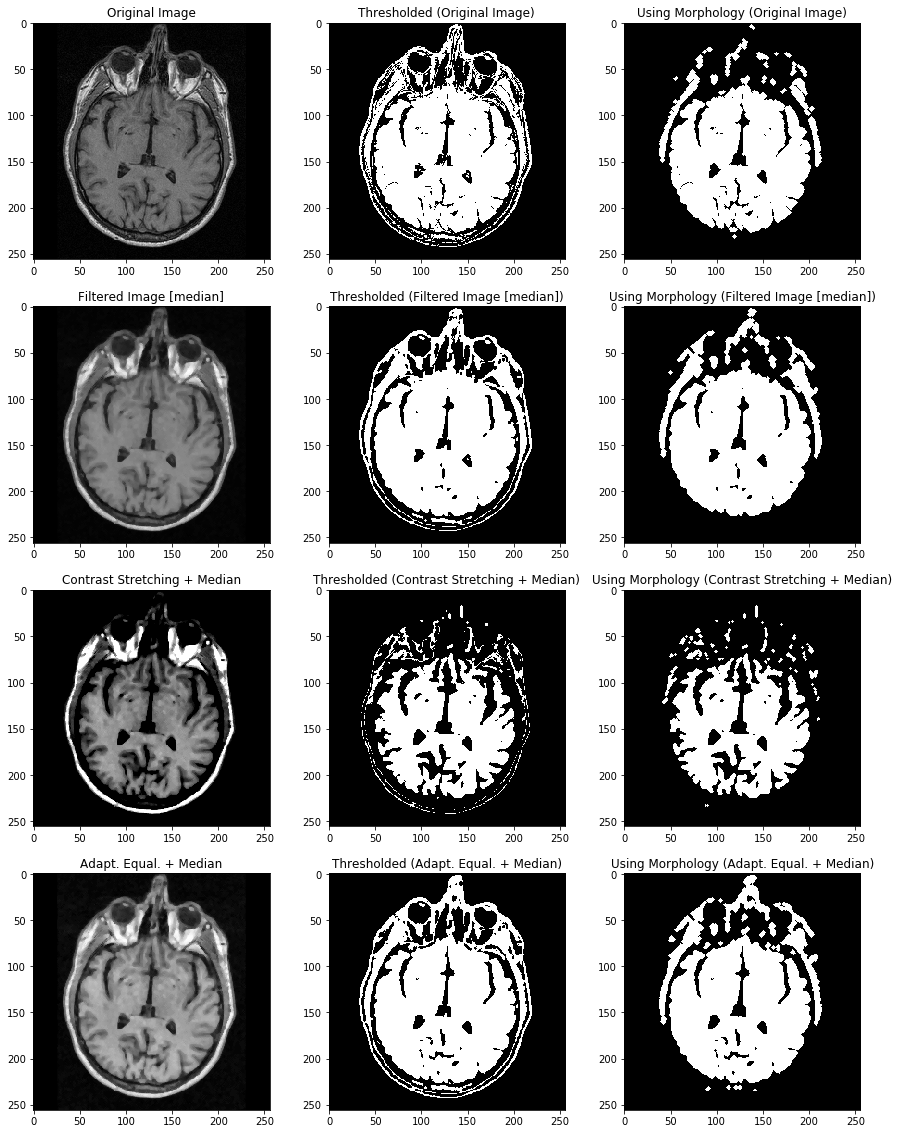

In [19]:
Otsu_brain_im_opened = opening(Otsu_brain_im, disk(2)); # Original Image
Otsu_median_brain_im_opened = opening(Otsu_median_brain_im, disk(2)); # Denoised Image
Otsu_exStretch_median_opened = opening(Otsu_exStretch_median, disk(1)); # Contrast Stretching on the Denoised Image
Otsu_exadapthist_median_opened = opening(Otsu_exadapthist_median, disk(2)); # Adaptive Equalization on the Denoised Image

multiplePlot3x3([brain_im, median_brain_im, exStretch_median, exadapthist_median], 
             [Otsu_brain_im, Otsu_median_brain_im, Otsu_exStretch_median, Otsu_exadapthist_median], 
             [Otsu_brain_im_opened, Otsu_median_brain_im_opened, Otsu_exStretch_median_opened, Otsu_exadapthist_median_opened], 
             ["Original Image", "Filtered Image [median]", "Contrast Stretching + Median", "Adapt. Equal. + Median"])

As seen, using disk size of "2" yields almost the same results for all the cases except the "Contrast Stretching + Median" case. Let's find the area of the brain using region growing:

In [20]:
label_brain_im = label(Otsu_brain_im_opened)
label_median_brain_im = label(Otsu_median_brain_im_opened)
label_exStretch_median = label(Otsu_exStretch_median_opened)
label_exadapthist_median = label(Otsu_exadapthist_median_opened)

brainRegionPlot([label_brain_im, label_median_brain_im, label_exStretch_median, label_exadapthist_median], 
                ["Original Image", "Filtered Image [median]", "Contrast Stretching + Median", "Adapt. Equal. + Median"])

### 1.3 Contour detection



### 1.3.1  Removing Noise
As the gradient based edge detectors are sensetive to noise, we apply a low-pass filter (median filter) to reduce noise while preserving the edges.  

In [21]:
median_brain_im=median(brain_im, disk(2))

### 1.3.2  Sobel Edge Detector
As edges are transitions between dark to light intenseties, we use kernels to take the derivetives of the image in both horizontal and vertical directions. Here, we use sobel kernels in both directions and obtain the magnitude of the derivate. Then, a threshold is soppused to find the binary edge map. 

In [22]:
gradient_h=sobel_h(median_brain_im)
gradient_v=sobel_v(median_brain_im)
magnitude_gradient= np.sqrt(gradient_h**2+gradient_v**2)
edge_sobel=magnitude_gradient>0.043


fig, ax = plt.subplots(ncols=1, sharex=True, sharey=True,
                       figsize=(5, 5))

ax.imshow(edge_sobel, cmap=plt.cm.gray)
ax.set_title('Edge Map - Using Sobel Kernel+Thresholding the Gradient Magnitude')
ax.axis('off');



plt.show()


Now using label function, the connected pixels with the same intenity value are selected. The segmented area (brain) is highlighted in blue and also the bounding box enlcosing the brain is drawn. 

In [23]:
label_image = label(1-edge_sobel)
image_label_overlay = label2rgb(label_image, image=brain_im)
regions = regionprops(label_image)

area=[]
for i in range(0,len(regions)):  
    area.append(regions[i].area)
    
area.sort()
import matplotlib.patches as mpatches
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(image_label_overlay)


for region in regionprops(label_image):
    if region.area == area[-2]:
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)
        ax.set_title("Labeled Image + Bounding Box" + ': Area of brain=' + str(region.area) + 'pixels')
        ax.axis('off');
plt.tight_layout()
plt.show()

### 1.3.2  Canny Edge Detector


In the Canny edge detector, firstly a gussian kernel is applied on the image to remove the noise (smooth the image). Secondly, the gradient magnitude and the direction of the image is computed. Then, a new gradient matrix is obtained after suppressing the nontrivial magnitudes. Next, considring two thresholds the strong and weak eadges are obtained. The final edge map is the union of the strong and weak edge pixels if they are connected to the strong edge pixels.      

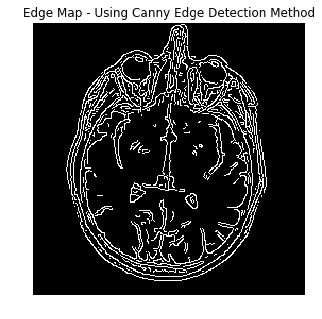

In [24]:
edges_canny = feature.canny(brain_im, sigma=0.5, 
                            low_threshold=60, high_threshold=80)

fig, ax = plt.subplots(ncols=1, sharex=True, sharey=True,
                       figsize=(5, 5))

ax.imshow(edges_canny,cmap=plt.cm.gray)
ax.set_title('Edge Map - Using Canny Edge Detection Method');
ax.axis('off');


To close the borders of the brain, morphological operation is used. 

In [25]:
edges_canny_closed = closing(edges_canny, square(5));
fig, ax = plt.subplots(1, 2, figsize=(10, 10));
ax[0].imshow(edges_canny,cmap='gray');
ax[0].axis('off');
ax[0].set_title("Edge Map")

ax[1].imshow(edges_canny_closed,cmap='gray');
ax[1].set_title("Morphological Operation to Fuse the Brain Border")
ax[1].axis('off');

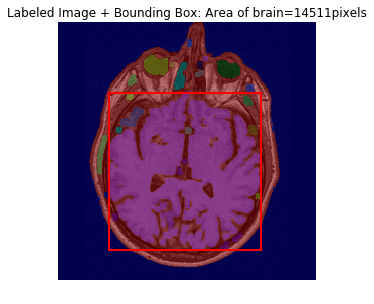

In [26]:
label_image = label(1-edges_canny_closed)
image_label_overlay = label2rgb(label_image, image=brain_im)
regions = regionprops(label_image)

area=[]
for i in range(0,len(regions)):  
    area.append(regions[i].area)
area.sort()

import matplotlib.patches as mpatches
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(image_label_overlay)


for region in regionprops(label_image):
    # take regions with large enough areas
    if region.area == area[-2]:
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)
        ax.set_title("Labeled Image + Bounding Box" + ': Area of brain=' + str(region.area) + 'pixels')
        ax.axis("off");

plt.tight_layout()
plt.show()

### 1.3.3  Laplacian of Gaussina (LOG)
Another way to find the maximums of the intensety function (edges), is the zero-crossing of the second derivative of the image where there is a transition from positive to negative or vice versa. In LOG, before calculating the second derivative, the image is filtered using a gaussian kernel with a sigma that is chosen based on the scale of details that we would like to obtain. In the block code below, the laplacian of the gaussian of the original image is calculated and then a threshold (=zero) is applied to show the boundary of the brain.  
     

It should be mentioned that although this way of thresholding is crude meaning that the areas where the second derivative is positive is displayed, it can show the boundary of the brain. To make the algorithm more sophisticated we needed to find the pixels where there is a transition between positive and negative. 

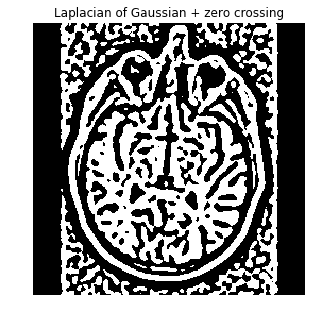

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5));

log_brain_im = ndimage.gaussian_laplace(img_as_float(brain_im), sigma=2.4)
log_brain_im=log_brain_im<0.0
ax.imshow(log_brain_im,cmap='gray');
ax.set_title("Laplacian of Gaussian + zero crossing")
ax.axis("off");

Now using the labeling function, we label different connected regions. It can be seen that there are some holes in the detected brain which resulted in smaller area than other methods. We have tried to use morphological operation to remove these small objects, but after applying them the boundary of the brain was getting open and the brain and the eye areas were recognized together.

In [28]:
label_image = label(log_brain_im)
image_label_overlay = label2rgb(label_image, image=brain_im)
regions = regionprops(label_image)

area=[]
for i in range(0,len(regions)):  
    area.append(regions[i].area)

area.sort()
import matplotlib.patches as mpatches
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(image_label_overlay)


for region in regionprops(label_image):
    # take regions with large enough areas
    if region.area == area[-1]:
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)
        ax.set_title("Labeled Image + Bounding Box" + ': Area of brain=' + str(region.area) + 'pixels')
        ax.axis("off");

plt.tight_layout()
plt.show()

### 1.4 Additional method(s)


An active contour based segmentation algorithm, Chan-Vese, is used in the next step. The algorithm is deigned for segmentation of objects without clearly defined boundaries- somehow the case we have with the brain image. The algorithm tries to minimize energy corresponding to weighted sum of values related to the sum of intensity differences from the average value outside the segmented region, the sum of differences from the average value inside the segmented region, and a term which is dependent on the length of the boundary of the segmented region.

Typical values for lambda1 and lambda2 are 1 while the ‘background’ is not very different from the segmented object in terms of distribution.

Typical values for mu are between 0 and 1, though higher values can be used when dealing with shapes with very ill-defined contours.

The algorithm also returns a list of values that corresponds to the energy at each iteration which can be used to adjust the various parameters described above.

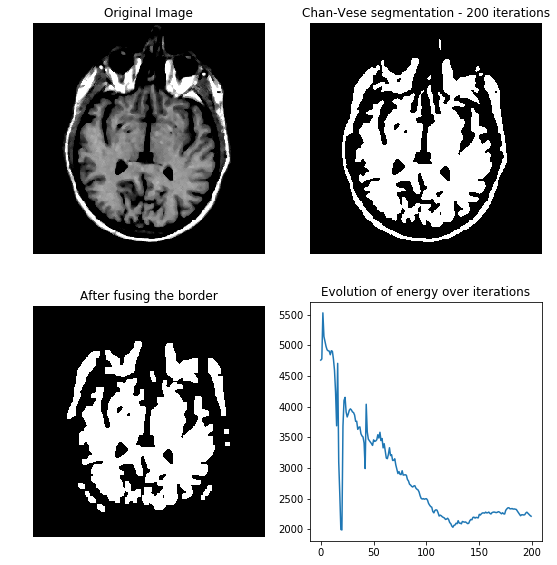

In [29]:
image = exStretch_median
cv = chan_vese(image, mu=0.1, lambda1=1, lambda2=1, tol=1e-3, max_iter=200,
               dt=1, init_level_set="checkerboard", extended_output=True)

fig, axes = plt.subplots(2, 2, figsize=(8, 8))
ax = axes.flatten()

cv_closed = opening(cv[0], square(5));


ax[0].imshow(image, cmap="gray")
ax[0].set_axis_off()
ax[0].set_title("Original Image", fontsize=12)

ax[1].imshow(cv[0], cmap="gray")
ax[1].set_axis_off()
title = "Chan-Vese segmentation - {} iterations".format(len(cv[2]))
ax[1].set_title(title, fontsize=12)

ax[2].imshow(cv_closed, cmap="gray")
ax[2].set_axis_off()
ax[2].set_title("After fusing the border", fontsize=12)

ax[3].plot(cv[2])
ax[3].set_title("Evolution of energy over iterations", fontsize=12)

fig.tight_layout()
plt.show()

In [30]:
label_image = label(cv_closed)
image_label_overlay = label2rgb(label_image, image=brain_im)
regions = regionprops(label_image)

area=[]
for i in range(0,len(regions)):  
    area.append(regions[i].area)

area.sort()
import matplotlib.patches as mpatches
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(image_label_overlay)


for region in regionprops(label_image):
    # take regions with large enough areas
    if region.area == area[-1]:
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)
        ax.set_title("Labeled Image + Bounding Box" + ': Area of brain=' + str(region.area) + 'pixels')
        ax.axis("off");

plt.tight_layout()
plt.show()

In [31]:
data = [['Method','Brain Area [pixels]'],
        ['Threshold: the Original Image', 17049],
        ['Threshold: Filtered Image [median]', 17840],
        ['Threshold: Contrast Stretching + Median', 13562],
        ['Threshold: Adapt. Equal. + Median', 17148],
        ['Edge Detector: Sobel', 13482],
        ['Edge Detector: Canny', 14511],
        ['Edge Detector: LoG', 11975],
        ['Segmentation: Chan-Vese', 12972],
        ]
    
    
display(HTML(
   '<table><tr>{}</tr></table>'.format(
       '</tr><tr>'.join(
           '<td>{}</td>'.format('</td><td>'.join(str(_) for _ in row)) for row in data)
       )
))

## Part 2: Save the bees !

Varroa mites are recognized as the biggest pest to honey bees worldwide, and are believed to be the single largest contributing factor in the modern-day decline of honey bees due to their ability to transmit diseases, resulting in death or severe deformity of the pupae. 

Detecting and quantifying the presence of Verroa in a beehive is therefore crucial to treat the infection appropriately and as early as possible, and image analysis appears very useful in this problem.

![Varroa Mite](https://lts5www.epfl.ch/wp-content/uploads/2018/07/varroa-2.jpg)



### 2.1 Introduction to Project

You will find hereafter a set of 4 images taken under real conditions. In this task you will be ask to:
1. Count the number of Varroa on each picture
2. Determine the Intersection over Union of the detected patterns w.r.t. the ground truth
3. Estimate the Precision, Recall and F1-score at two different IoU thresholds $T = {0.5 \text{, and } 0.9}$


**Note** 

Try to have the same routine(s) running on the four images, and giving (approximatively) the same results. The routine(s) that you will write for this part will be useful for the final project as well, so pay special attention to it.

#### Vocabulary


* **IoU**: Let $A$ be the ground truth area and $B$ the predicted one. the intersection over union (IoU) is given as:
$$IoU(A,B) = \frac{A \cap B}{A \cup B} = \frac{\text{Area of Overlap}}{\text{Area of Union}}$$
Let $T$ be a scalar in the interval $[0, 1]$, then $B$ will be considered as a true positive (TP) if and only if $IoU(A,B) \ge T$. As a results, we can evaluate the performance of our detection with different values of $T$. The larger $T$ is, the more constraining is our condition.


* **Precision**: The precision is given as:
$$precision = \frac{tp}{tp + fp}$$
where $tp$ is the number of true positives and $fp$ the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.


* **Recall**: The recall is given as:
$$precision = \frac{tp}{tp + fn}$$
where $tp$ is the number of true positives and $fn$ the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.


* **F1-score**: The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. The formula for the F1 score is:
$$F1 = \frac{2 \cdot precision \cdot recall}{precision + recall}$$


**FAQ**

Q: What to do if I have multiple ground truth $A_i$ and candidates $B_j$ and want to find the best set $(i,j)$ such that $(i, j) = \arg\max_{i,j} IoU(A_i, B_j)$ ? 

A: Here, we recommend to use a brute force approach. It corresponds to compute $IoU(A, B)$ for every possible pairs (i,j) and keep the pair with the highest $IoU$. Note that a candidate $B_j$ can **only** be matched to **one** ground truth area $A_i$.

## Extract relevant data
Here, we visualize the 4 images for our patern detection

In [32]:
# Load images
im_names = ['varroa-01', 'varroa-02', 'varroa-03', 'varroa-04']

data_path = os.path.join(os.getcwd(), 'data', 'lab-01-data')
filenames = [os.path.join(data_path, name) + '.jpg' for name in im_names]
ic = skimage.io.imread_collection(filenames)
print('Number of images: ', len(ic))

Number of images:  4


In [33]:
# Plot images
multiplePlot2x2(ic, im_names, ['hsv', 'hsv', 'hsv', 'hsv'])

### 2.2 Convert Image to Grayscale
As the varroa are much darker than the background and other objects in the image, required procedures can be performed on the garyscale image with a high and reasonable precision.

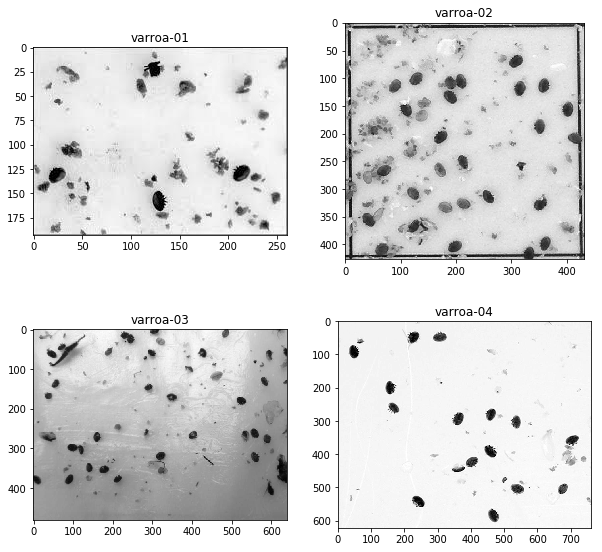

In [34]:
from skimage.color import rgb2gray
image_gray = []
for i in np.arange(len(filenames)):
    image_gray.append(rgb2gray(skimage.io.imread_collection(filenames)[i]))

# Plot images    
multiplePlot2x2(image_gray, im_names, ['gray', 'gray', 'gray', 'gray'])
    



### 2.3 Removing Noise 
To remove any possible noise off the image, "median" filter is applied to remove the noises while preserving the edges.


C:\IAPRAnaconda3\envs\iapr2019\lib\site-packages\skimage\util\dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


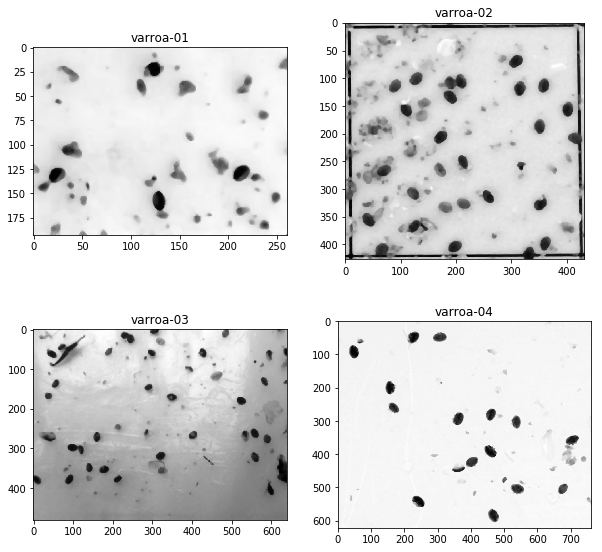

In [35]:
medianfiltered_image=[]
for i in np.arange(len(filenames)):
    medianfiltered_image.append(median(image_gray[i], disk(3)))
    
# Plot images
multiplePlot2x2(medianfiltered_image, im_names, ['gray', 'gray', 'gray', 'gray'])




### 2.3 Histogram
According to the histograms depicted below, the area of interest for all of the images has lower intensities than the background. 

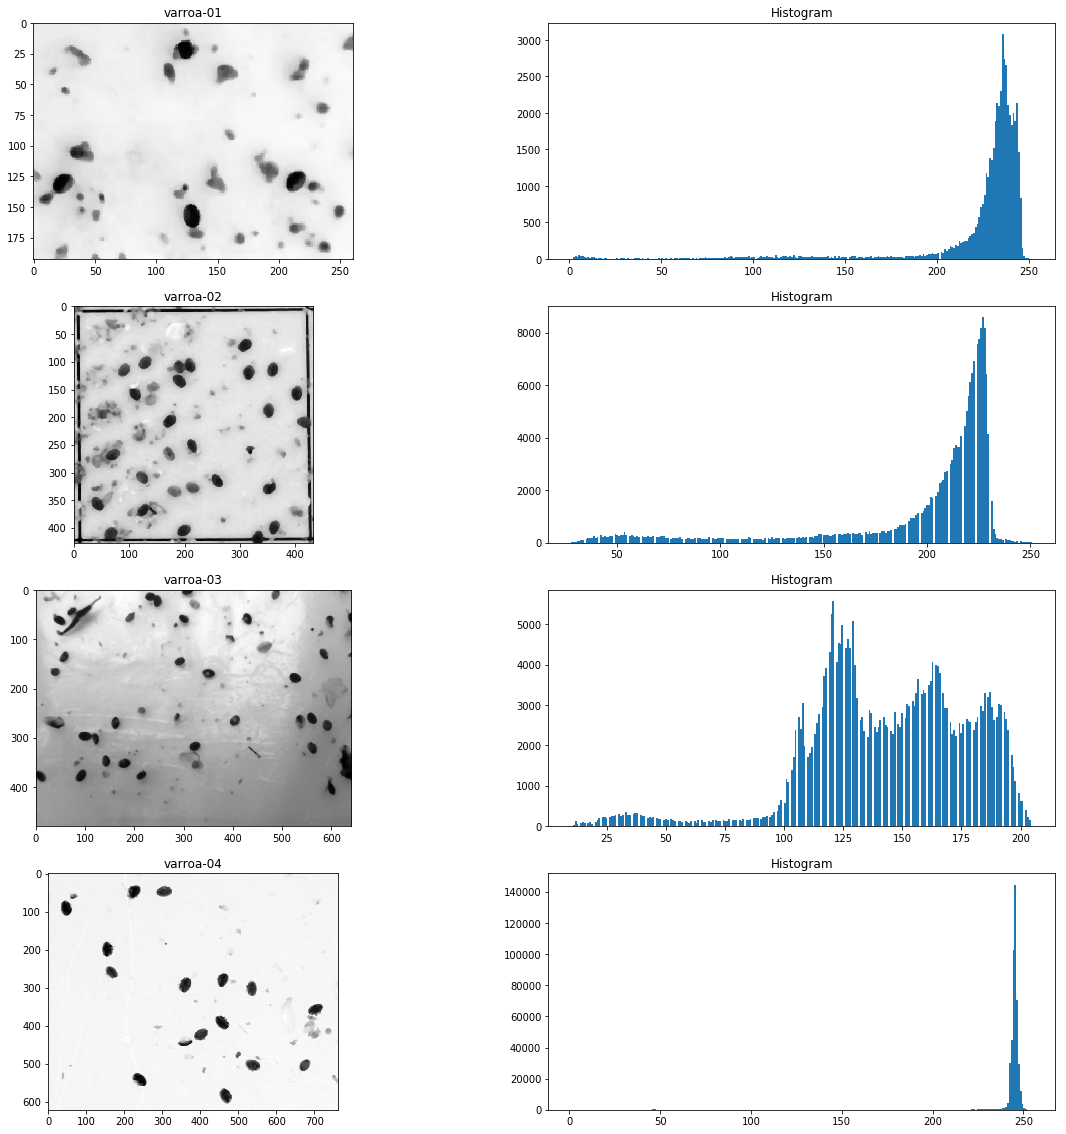

In [36]:
multipleImgHistGenerator(medianfiltered_image, im_names, ['gray','gray','gray','gray'])

### 2.4 Thresholding
Now, using the optimal thresholding, the forground is extracted from the background. 

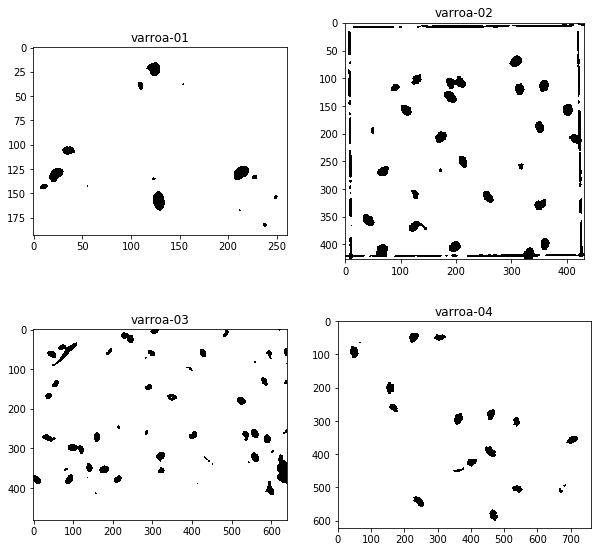

In [37]:
thresh=[]
binary=[]
cobinary=[]
thresh2=[]
binary2=[]

for i in np.arange(len(filenames)):
    thresh.append(skimage.filters.threshold_otsu(medianfiltered_image[i])) 
    binary.append(medianfiltered_image[i] > thresh[i])

    cobinary.append(medianfiltered_image[i] < thresh[i])

    thresh2.append(skimage.filters.threshold_otsu(medianfiltered_image[i][cobinary[i]]))
    binary2.append(medianfiltered_image[i] > thresh2[i]) 

# Plot images
multiplePlot2x2(binary2, im_names, ['gray', 'gray', 'gray', 'gray'])




### 2.4 Mathematical Morphology
Using morphological operations, the unwanted areas smaller than a structuring element are removed.

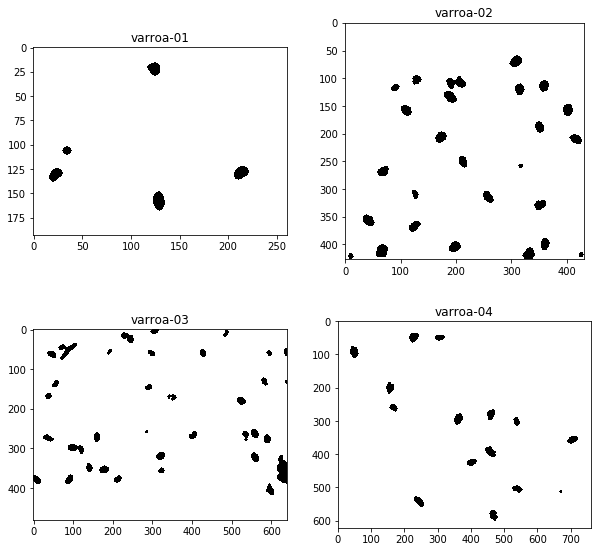

In [38]:
binary2_closed=[]
for i in np.arange(len(filenames)):
    binary2_closed.append(binary_closing(binary2[i], disk(4)))
    
# Plot images
multiplePlot2x2(binary2_closed, im_names, ['gray', 'gray', 'gray', 'gray'])


### 2.5 Region Labeling
Now, the connected black pixels are labeled using the "label" function.

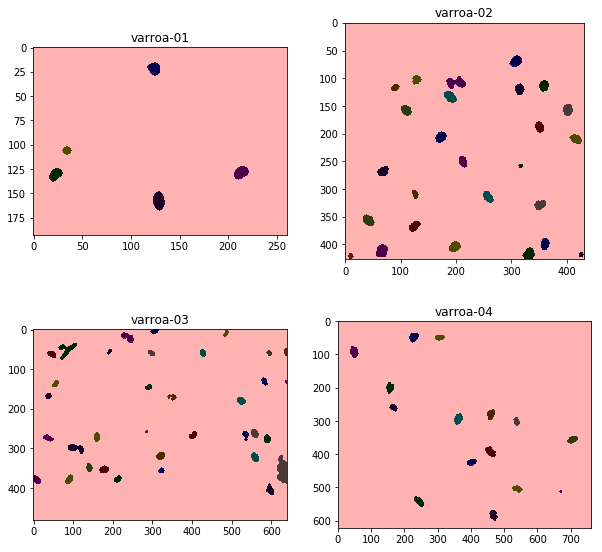

In [39]:
regions = []
label_image=[]
image_label_overlay=[]

for i in np.arange(len(filenames)):
    label_image.append(label(1-binary2_closed[i]))
    image_label_overlay.append(label2rgb(label_image[i], image=binary2_closed[i]))
    regions.append(regionprops(label_image[i]))

# Plot images
multiplePlot2x2(image_label_overlay, im_names, ['hsv', 'hsv', 'hsv', 'hsv'])


As the mites are natural unique species, their overal shape is supposed to be similar to each other. Here, we have defined two features namely, the major axis length and also the ratio of the major to minor axis length of the fitted ellipse. The introduced features are used to cluter the regions. 

In [40]:
def mite_detector(f_regions):
    num_photos = len(f_regions)
    max_ax_length_all = []
    ratio_max_min_all = []
    
    for image_no in np.arange(num_photos):
        num_regions = len(f_regions[image_no])
        min_ax_length=[]
        max_ax_length=[]

        for region in np.arange(len(regions[image_no])): 
            min_ax_length.append(regions[image_no][region].minor_axis_length)
            max_ax_length.append(regions[image_no][region].major_axis_length)  

        ratio_max_min_all.append([x/y for x,y in zip(max_ax_length,min_ax_length)])
        max_ax_length_all.append(max_ax_length)
        
    return ratio_max_min_all, max_ax_length_all
    
[ratio, maxLen] = mite_detector(regions)

C:\IAPRAnaconda3\envs\iapr2019\lib\site-packages\skimage\measure\_regionprops.py:250: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See http://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)
C:\IAPRAnaconda3\envs\iapr2019\lib\site-packages\skimage\measure\_regionprops.py:260: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See http://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)


Above defined features for each image are stored in the list **"feature_all"**.

In [41]:
num_photos = len(regions)
feature_all=[]
for image_no in np.arange(num_photos):
    feature = []
    for region in np.arange(len(regions[image_no])):
        feature.append([ratio[image_no][region], maxLen[image_no][region]])
    feature_all.append(feature)

In [42]:
imageFeatures=[]
imageFeatures_normaized=[]
for image_no in np.arange(num_photos):
    imageFeatures.append(np.array(feature_all[image_no]))
    # Normalize the features 
    imageFeatures_normaized.append(
        [[x,y] for x,y in zip(imageFeatures[image_no][:,0]/max(imageFeatures[image_no][:,0]),imageFeatures[image_no][:,1]/max(imageFeatures[image_no][:,1]))])

### 2.6 Count the number of Varroa on each picture (K-means Clustering)
It is considered that upto three regions exist in the image: mites(desired region), small unwanted objects, large unwanted objects. Utilized thresholding and morphological methods are meant to reduce the number of unwanted objects as  much as possible. Therefore, the cluster "mite" has the highest number of samples.


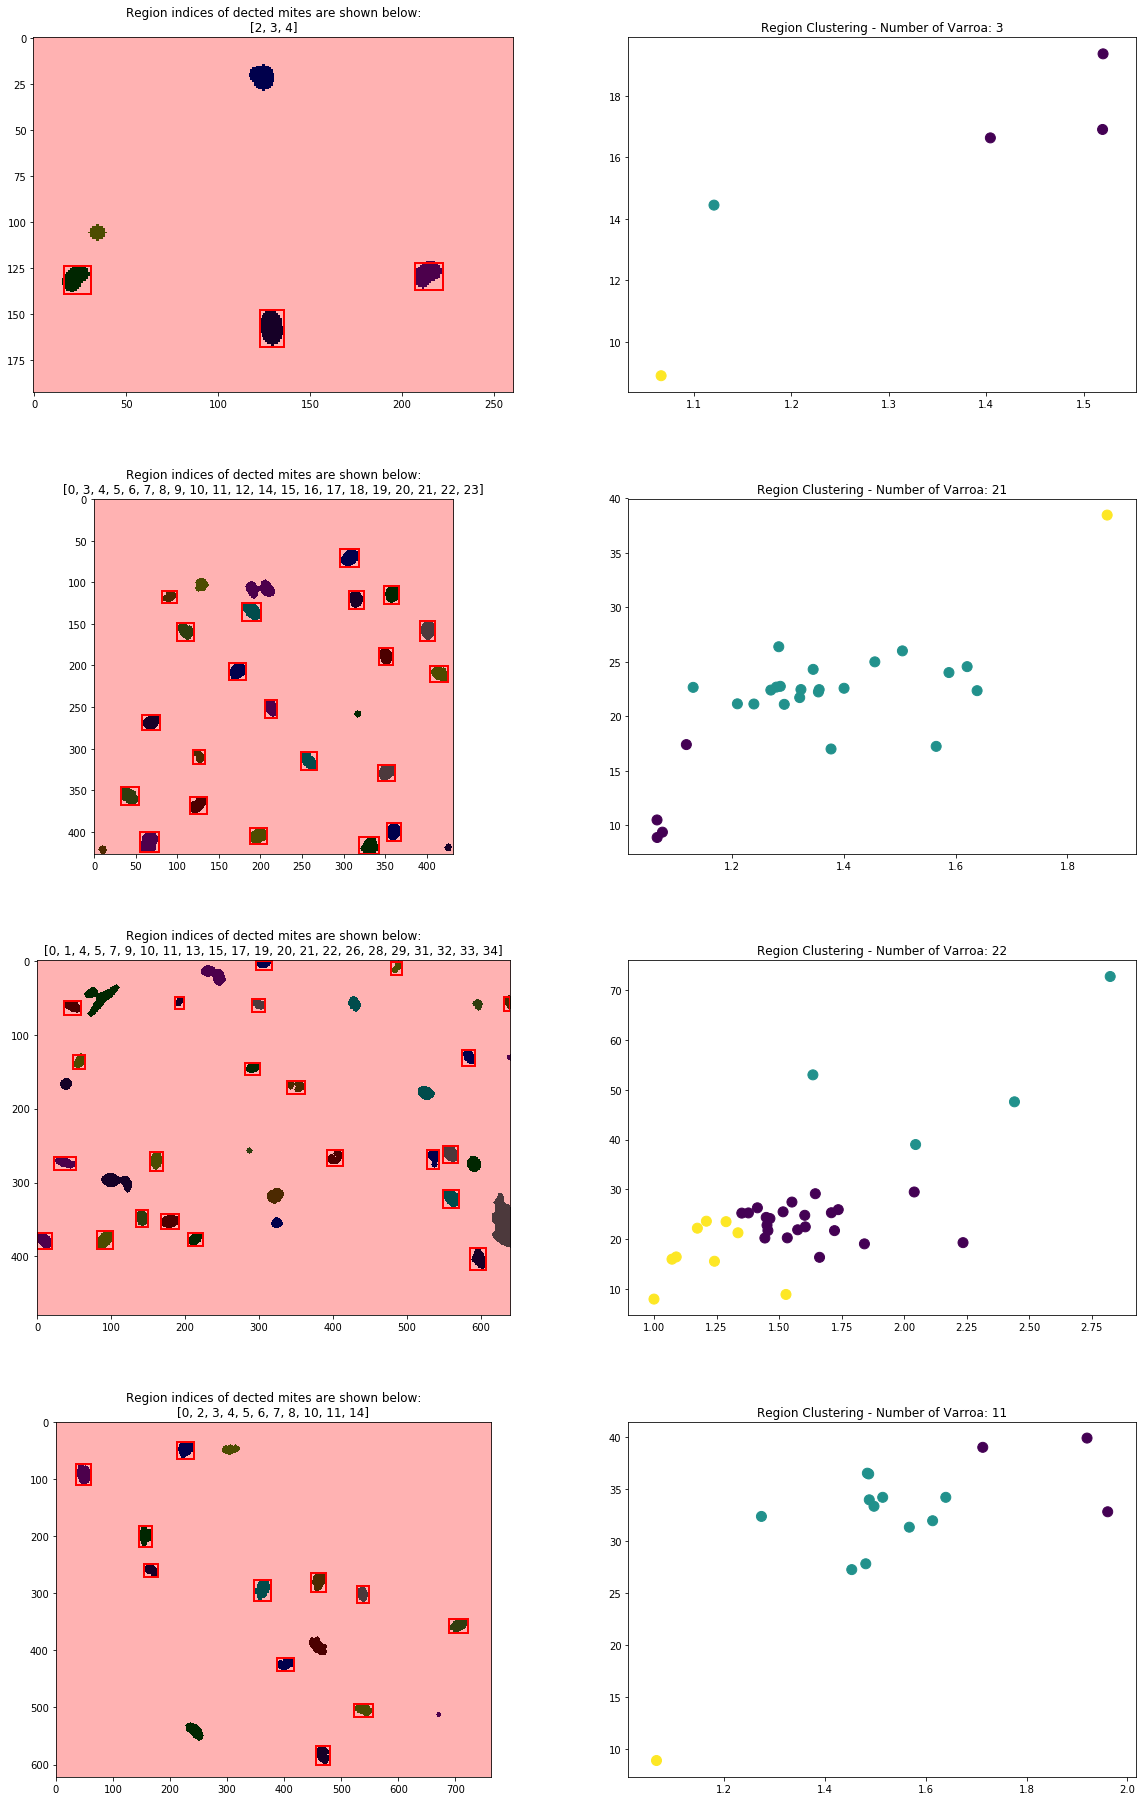

In [43]:
fig = plt.figure(figsize=(20,8 * num_photos))
fig.subplots_adjust(hspace = 0.3)
itemCounter = 0
    
kmeans = (KMeans(n_clusters=3))
y_kmeans_list = []
indices_list = []

for image_no in np.arange(num_photos):
    kmeans.fit(imageFeatures_normaized[image_no])
    y_kmeans = (kmeans.predict(imageFeatures_normaized[image_no]))
    y_kmeans_list.append(y_kmeans)
    
    indices = [i for i, x in enumerate(y_kmeans) if x == mode(y_kmeans)]
    indices_list.append(indices)
    
    ax1 = plt.subplot2grid((num_photos,2), (itemCounter,0), rowspan=1, colspan=1)
    ax2 = plt.subplot2grid((num_photos,2), (itemCounter,1), rowspan=1, colspan=1)
    
    ax1.imshow(image_label_overlay[image_no])
    ax1.set_title('Region indices of dected mites are shown below:\n' + str(indices))
    ax2.scatter(imageFeatures[image_no][:, 0], imageFeatures[image_no][:, 1], c=y_kmeans, s=100, cmap='viridis');
    ax2.set_title("Region Clustering - Number of Varroa: " + str(len(indices)))
    for i in indices:
        minr, minc, maxr, maxc = regions[image_no][i].bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax1.add_patch(rect)
    
    itemCounter += 1
    
plt.show()

### 2.7 Ground Truth

In [44]:
import xml.etree.ElementTree as ET

def parse_file(filename):
    """ Parse a PASCAL VOC xml file """
    tree = ET.parse(filename)
    objects = []
    for obj in tree.findall('object'):
        obj_struct = {}
        obj_struct['name'] = obj.find('name').text
        bbox = obj.find('bndbox')
        obj_struct['bbox'] = [int(float(bbox.find('xmin').text)),
                              int(float(bbox.find('ymin').text)),
                              int(float(bbox.find('xmax').text))-int(float(bbox.find('xmin').text)),
                              int(float(bbox.find('ymax').text))-int(float(bbox.find('ymin').text))]
        objects.append(obj_struct)

    return objects

annotations_xmls = [parse_file(os.path.join(data_path, name) + '.xml') for name in im_names]

# Plot images
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
for ax, im, nm, annotations in zip(axes.ravel(), ic, im_names, annotations_xmls):
    # Iterate over annotations
    for anno in annotations:
        rect = patches.Rectangle((anno['bbox'][0], anno['bbox'][1]), anno['bbox'][2], anno['bbox'][3],
                linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
    
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

### 2.7 IoU of the detected pattern w.r.t. the ground truth
A and B lists are the area regions corresponding to **ground truth** and **detected varroa**, respectively.

In [45]:
Atotal = []
for image_no in np.arange(num_photos):
    A = []
    for anno in annotations_xmls[image_no]:
        Atmp = np.zeros(((np.size(binary2_closed[image_no], 0),np.size(binary2_closed[image_no], 1))))
        Atmp[anno['bbox'][1]:anno['bbox'][1] + anno['bbox'][3], anno['bbox'][0]:anno['bbox'][0] + anno['bbox'][2]] = 1
        A.append(np.array(Atmp))
    Atotal.append(A)

Btotal = []
for image_no in np.arange(num_photos):
    B = []
    for i in indices_list[image_no]:
        Btmp = np.zeros(((np.size(binary2_closed[image_no], 0),np.size(binary2_closed[image_no], 1))))
        minr, minc, maxr, maxc = regions[image_no][i].bbox
        Btmp[minr:maxr, minc:maxc] = 1
        B.append(np.array(Btmp))
    Btotal.append(B)

In [46]:
IOU_total = []
for image_no in np.arange(num_photos):
    IOU = np.zeros((len(Atotal[image_no]), len(Btotal[image_no])))
    BCounter = 0
    for Bitem in Btotal[image_no]:
        ACounter = 0
        for Aitem in Atotal[image_no]:
            intersection = np.logical_and(Aitem, Bitem)
            union = np.logical_or(Aitem, Bitem)
            intersectionArea = np.sum(intersection)
            unionArea = np.sum(union)
            IOU[ACounter, BCounter] = intersectionArea / unionArea
            ACounter += 1
        BCounter += 1 
    IOU_total.append(IOU)

Now the best set $(i,j)$ such that $(i, j) = \arg\max_{i,j} IoU(A_i, B_j)$

In [47]:
max_IOU_total=[]
fn_IOU_total = []
tp1=[]
fp1=[]
fn1=[]
precision1=[]
recall1=[]
F1_1=[]

for image_no in np.arange(num_photos):
    max_IOU = []
    for BItemNo in np.arange(len(Btotal[image_no])):
        max_IOU.append((max(IOU_total[image_no][:, BItemNo])))
    max_IOU_total.append(max_IOU)
    
    fn_IOU = []
    for AItemNo in np.arange(len(Atotal[image_no])):
        fn_IOU.append((max(IOU_total[image_no][AItemNo, :])))
    fn_IOU_total.append(fn_IOU)
    
    
    thresholdTP1 = np.array(max_IOU_total[image_no])> 0.9  # T=0.9
    tp1.append(np.sum(thresholdTP1))
    fp1.append(len(Btotal[image_no])-tp1[image_no])
    precision1.append(np.round(tp1[image_no]/(tp1[image_no]+fp1[image_no]),1))
    
    thresholdFN1=np.array(fn_IOU_total[image_no]) < 0.9 # T=0.9
    fn1.append(np.sum(thresholdFN1))
    recall1.append(np.round(tp1[image_no]/(tp1[image_no]+fn1[image_no]),1))
    
    F1_1.append(np.round((2 * precision1[image_no] * recall1[image_no]) / (precision1[image_no] + recall1[image_no]),1))


C:\IAPRAnaconda3\envs\iapr2019\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars


In [48]:
tp2=[]
fp2=[]
fn2=[]
precision2=[]
recall2=[]
F1_2=[]

for image_no in np.arange(num_photos):   
    thresholdTP2 = np.array(max_IOU_total[image_no])> 0.5  # T=0.5
    tp2.append(np.sum(thresholdTP2))
    fp2.append(len(Btotal[image_no])-tp2[image_no])
    precision2.append(np.round(tp2[image_no]/(tp2[image_no]+fp2[image_no]),1))
    
    thresholdFN2=np.array(fn_IOU_total[image_no]) < 0.5 # T=0.5
    fn2.append(np.sum(thresholdFN2))
    recall2.append(np.round(tp2[image_no]/(tp2[image_no]+fn2[image_no]),1))
    
    F1_2.append(np.round((2 * precision2[image_no] * recall2[image_no]) / (precision2[image_no] + recall2[image_no]),1))

### 2.8 Precision, Recall and F1-score at two different IoU thresholds

In [49]:
data1 = [['T=0.9','Varroa-01','Varroa-02','Varroa-03','Varroa-04'],
        ['# True Positive', 0, 0, 0, 0],
        ['# False Positive', 0, 0, 0, 0],
        ['# False Negative', 0, 0, 0, 0],
        ['Precision', 0, 0, 0, 0],
        ['Recall', 0, 0, 0, 0],
        ['F1', 0, 0, 0, 0],
        ]

for image_no in np.arange(num_photos):   
    data1[1][image_no + 1] = tp1[image_no]
    data1[2][image_no + 1] = fp1[image_no]
    data1[3][image_no + 1] = fn1[image_no]
    data1[4][image_no + 1] = precision1[image_no]
    data1[5][image_no + 1] = recall1[image_no]
    data1[6][image_no + 1] = F1_1[image_no]
    
    
display(HTML(
   '<table><tr>{}</tr></table>'.format(
       '</tr><tr>'.join(
           '<td>{}</td>'.format('</td><td>'.join(str(_) for _ in row)) for row in data1)
       )
))

data2 = [['T=0.5','Varroa-01','Varroa-02','Varroa-03','Varroa-04'],
        ['# True Positive', 0, 0, 0, 0],
        ['# False Positive', 0, 0, 0, 0],
        ['# False Negative', 0, 0, 0, 0],
        ['Precision', 0, 0, 0, 0],
        ['Recall', 0, 0, 0, 0],
        ['F1', 0, 0, 0, 0],
        ]

for image_no in np.arange(num_photos):   
    data2[1][image_no + 1] = tp2[image_no]
    data2[2][image_no + 1] = fp2[image_no]
    data2[3][image_no + 1] = fn2[image_no]
    data2[4][image_no + 1] = precision2[image_no]
    data2[5][image_no + 1] = recall2[image_no]
    data2[6][image_no + 1] = F1_2[image_no]
    
    
display(HTML(
   '<table><tr>{}</tr></table>'.format(
       '</tr><tr>'.join(
           '<td>{}</td>'.format('</td><td>'.join(str(_) for _ in row)) for row in data2)
       )
))

As seen, the 0.9 threshold is so strict that although the number of detected mites are almost equal to the ground truth -for example : varroa-01-, it results in precision of zero! The case is not so critical for the 0.5 threshold.

It is suggested that the IoU parameter is defined as the **ratio of "area of overlap" to "the smallest area of the two"**. Consider a rather small bonding box of ground truth being inside a rather large bonding box of detection procedure. The intersection would be equal to area of the smaller bonding box and the union would be equal to the area of the bigger bonding box leading to a precision under 1. If the proposed threshold is used, the results would be as follows:

In [50]:
proposed_IOU_total = []
for image_no in np.arange(num_photos):
    proposed_IOU = np.zeros((len(Atotal[image_no]), len(Btotal[image_no])))
    BCounter = 0
    for Bitem in Btotal[image_no]:
        ACounter = 0
        for Aitem in Atotal[image_no]:
            proposed_intersection = np.logical_and(Aitem, Bitem)
            proposed_union = np.logical_or(Aitem, Bitem)
            proposed_intersectionArea = np.sum(proposed_intersection)
            proposed_unionArea = min(np.sum(Aitem), np.sum(Bitem))
            proposed_IOU[ACounter, BCounter] = proposed_intersectionArea / proposed_unionArea
            ACounter += 1
        BCounter += 1 
    proposed_IOU_total.append(proposed_IOU)

In [51]:
proposed_max_IOU_total=[]
proposed_fn_IOU_total = []
proposed_tp1=[]
proposed_fp1=[]
proposed_fn1=[]
proposed_precision1=[]
proposed_recall1=[]
proposed_F1_1=[]

for image_no in np.arange(num_photos):
    proposed_max_IOU = []
    for BItemNo in np.arange(len(Btotal[image_no])):
        proposed_max_IOU.append((max(proposed_IOU_total[image_no][:, BItemNo])))
    proposed_max_IOU_total.append(proposed_max_IOU)
    
    proposed_fn_IOU = []
    for AItemNo in np.arange(len(Atotal[image_no])):
        proposed_fn_IOU.append((max(proposed_IOU_total[image_no][AItemNo, :])))
    proposed_fn_IOU_total.append(proposed_fn_IOU)
    
    proposed_thresholdTP1 = np.array(proposed_max_IOU_total[image_no])> 0.9  # T=0.9
    proposed_tp1.append(np.sum(proposed_thresholdTP1))
    proposed_fp1.append(len(Btotal[image_no]) - proposed_tp1[image_no])
    proposed_precision1.append(np.round(proposed_tp1[image_no] / (proposed_tp1[image_no] + proposed_fp1[image_no]),2))
    
    proposed_thresholdFN1=np.array(proposed_fn_IOU_total[image_no]) < 0.9 # T=0.9
    proposed_fn1.append(np.sum(proposed_thresholdFN1))
    proposed_recall1.append(np.round(proposed_tp1[image_no] / (proposed_tp1[image_no] + proposed_fn1[image_no]),2))
    
    proposed_F1_1.append(np.round((2 * proposed_precision1[image_no] * proposed_recall1[image_no]) / (proposed_precision1[image_no] + proposed_recall1[image_no]),2))


In [52]:
proposed_tp2=[]
proposed_fp2=[]
proposed_fn2=[]
proposed_precision2=[]
proposed_recall2=[]
proposed_F1_2=[]

for image_no in np.arange(num_photos):   
    proposed_thresholdTP2 = np.array(proposed_max_IOU_total[image_no])> 0.5  # T=0.5
    proposed_tp2.append(np.sum(proposed_thresholdTP2))
    proposed_fp2.append(len(Btotal[image_no]) - proposed_tp2[image_no])
    proposed_precision2.append(np.round(proposed_tp2[image_no] / (proposed_tp2[image_no] + proposed_fp2[image_no]),2))
    
    proposed_thresholdFN2=np.array(proposed_fn_IOU_total[image_no]) < 0.5 # T=0.5
    proposed_fn2.append(np.sum(proposed_thresholdFN2))
    proposed_recall2.append(np.round(proposed_tp2[image_no] / (proposed_tp2[image_no] + proposed_fn2[image_no]),2))
    
    proposed_F1_2.append(np.round((2 * proposed_precision2[image_no] * proposed_recall2[image_no]) / (proposed_precision2[image_no] + proposed_recall2[image_no]),2))

In [53]:
proposed_data1 = [['T=0.9','Varroa-01','Varroa-02','Varroa-03','Varroa-04'],
        ['# True Positive', 0, 0, 0, 0],
        ['# False Positive', 0, 0, 0, 0],
        ['# False Negative', 0, 0, 0, 0],
        ['Precision', 0, 0, 0, 0],
        ['Recall', 0, 0, 0, 0],
        ['F1', 0, 0, 0, 0],
        ]

for image_no in np.arange(num_photos):   
    proposed_data1[1][image_no + 1] = proposed_tp1[image_no]
    proposed_data1[2][image_no + 1] = proposed_fp1[image_no]
    proposed_data1[3][image_no + 1] = proposed_fn1[image_no]
    proposed_data1[4][image_no + 1] = proposed_precision1[image_no]
    proposed_data1[5][image_no + 1] = proposed_recall1[image_no]
    proposed_data1[6][image_no + 1] = proposed_F1_1[image_no]
    
    
display(HTML(
   '<table><tr>{}</tr></table>'.format(
       '</tr><tr>'.join(
           '<td>{}</td>'.format('</td><td>'.join(str(_) for _ in row)) for row in proposed_data1)
       )
))

proposed_data2 = [['T=0.5','Varroa-01','Varroa-02','Varroa-03','Varroa-04'],
        ['# True Positive', 0, 0, 0, 0],
        ['# False Positive', 0, 0, 0, 0],
        ['# False Negative', 0, 0, 0, 0],
        ['Precision', 0, 0, 0, 0],
        ['Recall', 0, 0, 0, 0],
        ['F1', 0, 0, 0, 0],
        ]

for image_no in np.arange(num_photos):   
    proposed_data2[1][image_no + 1] = proposed_tp2[image_no]
    proposed_data2[2][image_no + 1] = proposed_fp2[image_no]
    proposed_data2[3][image_no + 1] = proposed_fn2[image_no]
    proposed_data2[4][image_no + 1] = proposed_precision2[image_no]
    proposed_data2[5][image_no + 1] = proposed_recall2[image_no]
    proposed_data2[6][image_no + 1] = proposed_F1_2[image_no]
    
    
display(HTML(
   '<table><tr>{}</tr></table>'.format(
       '</tr><tr>'.join(
           '<td>{}</td>'.format('</td><td>'.join(str(_) for _ in row)) for row in proposed_data2)
       )
))